In [1]:
#!/usr/bin/env python3

import re
from bs4 import BeautifulSoup
from requests import get
import matplotlib.pyplot as plt
import numpy as np


def extract_imdb_id(s: str) -> str:
    """ Extrahiert aus einem 'title/tt121345/bla' string die 
        IMDB id tt12345 und gibt diese zurück. """
    return re.search("/title/(.*)/", s).group(1)


def extract_num_seasons(s: str) -> int:
    """ Extrahiert aus einem String, der mit einer Zahl beginnt, 
        diese Zahl und gibt diese als int zurück."""
    return int(re.search(r"^\d*", s).group(0))


def extract_num_votes(s: str) -> int:
    """ Extrahiert aus einem String '(1234,2345)' die Zahl und gibt 
        diese Zurück (achtung: anglistisches Format) """
    return int(re.search("[0-9]+,*[0-9]+", s).group(0).replace(",", ""))

**1. Besuche https://imdb.com, suche nach deiner Lieblingsserie und analysiere mittels Chrome den Suchvorgang, wie man die *IMDB ID* deiner Lieblingsserie *parsen* könnte.**

**2. Schreibe eine Funktion `scrape_imdb_id(name: str) -> str`, welche den Seriennamen als Argument besitzt und die IMDB ID
als String zurückgibt.**

In [2]:
def scrape_imdb_id(name: str) -> str:
    # 1. Leerzeichen muessen durch "+" ersetzt werden:
    search_url = f"https://www.imdb.com/find?q=" + \
        name.replace(" ", "+") + "&ref_=nv_sr_sm"
    # 2. MainSoup der Suche
    soup = BeautifulSoup(get(search_url).text, "lxml")
    # 3. Finde den 'href'-Wert des ersten Suchergebnisses
    href = soup.find("td", class_="result_text").a["href"]
    # 4. Extrahiere die IMDB ID aus dem href-string
    imdb_id = extract_imdb_id(href)
    return imdb_id


**3. Analysiere, wie man die Anzahl der Staffeln deiner Serie *scrapen* könnte und implementiere eine Funktion `scrape_num_seasons(imdb_id: str) -> int`, welche die IMDB ID als Argument erwartet und die Anzahl der Staffeln als zurückgibt.**

In [3]:
def scrape_num_seasons(imdb_id: str) -> int:
    search_url = f"https://www.imdb.com/title/{imdb_id}/?ref_=fn_al_tt_1"
    soup = BeautifulSoup(get(search_url).text, "lxml")
    return extract_num_seasons(soup.find(id="browse-episodes-season")["aria-label"])


**4.Analysiere, wie man die Durchschnittsbewertung jeder einzelnen Episode einer Staffel und die Anzahl der abgegebenen Bewertungen *parsen* könnte. Implementiere anschließend eine Funktion `scrape_ratings(imdb_id: str, season: int) -> Tuple[List[float], List[int]]`, welche für die Staffel `season` die Durchschnittsbewertungen aller Folgen und die jeweilige Anzahl der abgegeben Bewertungen jeweils als Liste zurückgibt.**

In [4]:
from typing import Tuple, List

def scrape_ratings(imdb_id: str, season: int) -> Tuple[List[float], List[int]]:
    search_url = f"https://www.imdb.com/title/{imdb_id}/episodes?season={season}"
    soup = BeautifulSoup(get(search_url).text, "lxml")
    spans = soup.find_all("div", class_="ipl-rating-star small")
    ratings, num_votes = [], []
    for span in spans:
        ratings += [float(span.find(class_="ipl-rating-star__rating").text)]
        num_votes += [extract_num_votes(span.find(class_="ipl-rating-star__total-votes").text)]
    return ratings, num_votes

**5. Probiere deine implementierten Funktionen aus, indem du dir die Bewertungen deiner Lieblingsserie plottest**

In [5]:
def plot_ratings(serienname: str, regress_all=False) -> None:
    imdb_id = scrape_imdb_id(serienname)
    num_seasons = scrape_num_seasons(imdb_id)
    # Für den Plot
    plt.title(serienname)
    plt.xlabel("Episode")
    plt.ylabel("Rating")
    k = 0
    all_ratings = []
    for season in range(1, num_seasons + 1):
        ratings, num_votes = scrape_ratings(imdb_id, season)
        episodes = np.arange(len(ratings)) + k
        k += len(ratings)
        p = plt.plot(episodes, ratings, ".", label=f"Staffel {season}")
        # Koeffizienten der Regressionsgerade
        coefs = np.polyfit(episodes, ratings, 1)
        plt.plot(episodes, np.poly1d(coefs)(episodes), color=p[0].get_color())
        if regress_all:
            all_ratings += ratings
    # Regression über alle Staffeln
    if regress_all:
        all_episodes = np.arange(len(all_ratings))
        coefs = np.polyfit(all_episodes, all_ratings, 1)
        plt.plot(all_episodes, np.poly1d(coefs)(all_episodes), "--", label="Alle Staffeln")
    plt.legend()
    plt.show()

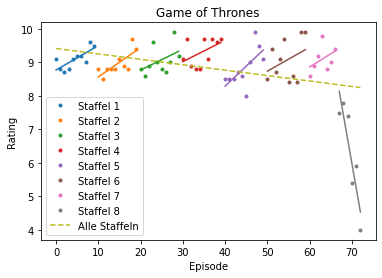

In [7]:
plot_ratings("Game of Thrones", regress_all=True)
